In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from calcwf import *
from interpolating_match import *

Let's first take a look at the (quad) mismatch between harmonics generated at different fiducial eccentricities with the non-eccentric waveform along the degeneracy line for different chirp masses.

In [4]:
# Find mismatches for a range of fid_e values
def find_quad_mismatches(chirp, fid_es, n, q=2, f_low=10, sample_rate=4096, approximant='TEOBResumS'):

    # Generate non-eccentric waveform
    h = gen_wf(f_low, 0, chirp2total(chirp, q), q, sample_rate, approximant)

    # Generate chirp masses along degeneracy line
    fid_chirps = favata_et_al_avg(0, chirp, fid_es, sample_rate, f_low=f_low, q=q)

    # Calculate mismatch for each fid_e
    mismatches = []
    for i, (fid_e, fid_chirp) in enumerate(zip(fid_es, fid_chirps)):
        all_wfs = list(get_h([1]*n, f_low, fid_e, chirp2total(fid_chirp, q), q, sample_rate, approximant=approximant))
        matches = match_hn(all_wfs[1:n+1], h, f_low)
        quad_match = np.sqrt(np.sum(np.abs(matches)**2))
        mismatches.append(1-quad_match)
        print(f'\r{i+1} done out of {len(fid_es)}', end='')
    print('')

    return np.array(mismatches)

In [13]:
# Calculate mismatches for 10, 30, and 70 chirp masses
# mismatches_10 = find_quad_mismatches(10, np.linspace(0,0.15,16), 4)
mismatches_30 = find_quad_mismatches(30, np.linspace(0,0.30,31), 4)
mismatches_70 = find_quad_mismatches(70, np.linspace(0,0.50,51), 4)

31 done out of 31

51 done out of 51



(0.0, 0.007)

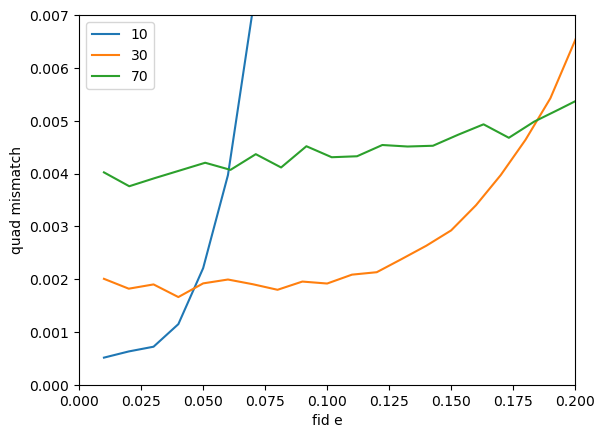

In [18]:
plt.plot(np.linspace(0.01,0.15,15), mismatches_10[1:], label='10')
plt.plot(np.linspace(0.01,0.30,30), mismatches_30[1:], label='30')
plt.plot(np.linspace(0.01,0.51,50), mismatches_70[1:], label='70')
plt.legend()
plt.xlabel('fid e')
plt.ylabel('quad mismatch')
plt.xlim(0,0.2)
plt.ylim(0,0.007)